In [2]:
from custom_functions import *
sns.set(style="whitegrid", font_scale=1.5)
plt.style.use('paper.mplstyle.txt')
markers = ('o', 'v', 's', 'd', '<', '+')

sys.path.insert(0, "../compass")
from parameters import FLAGS
from model import CompassModel

# filename = "../compass/maps/noord/agents_noord.pickle"
# filename = "../compass/maps/amsterdam/agents_3p.pickle"
filename = "../compass/maps/agents_amsterdam_q1q5_dist.pickle"
with open(filename, "rb") as f:
    data = pickle.load(f)

# More agents are simulated to sample from them and incorporate some 
# randomness in the type and spatial distribution
perc_of_actual = data['perc_of_actual']
total_households = len(data['households'])
actual_households = int(total_households / perc_of_actual)
print(total_households, actual_households)

40159 33465


In [3]:
rows = []
points = []
categories = []
for household in data['households']:
    point, category = extract_data(household)
    categories.append(category)
    points.append(Point(point))
    row = []
    row += list(household.distances.values())[:-2]
    rows.append(row)
np_distances = np.array(rows)

In [4]:
rand_int = np.random.randint(len(data['households']))
random_household = data['households'][rand_int]
point, category = extract_data(random_household)

C:\Users\edignum\.virtualenvs\compassproject-OUBZ_QZN\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


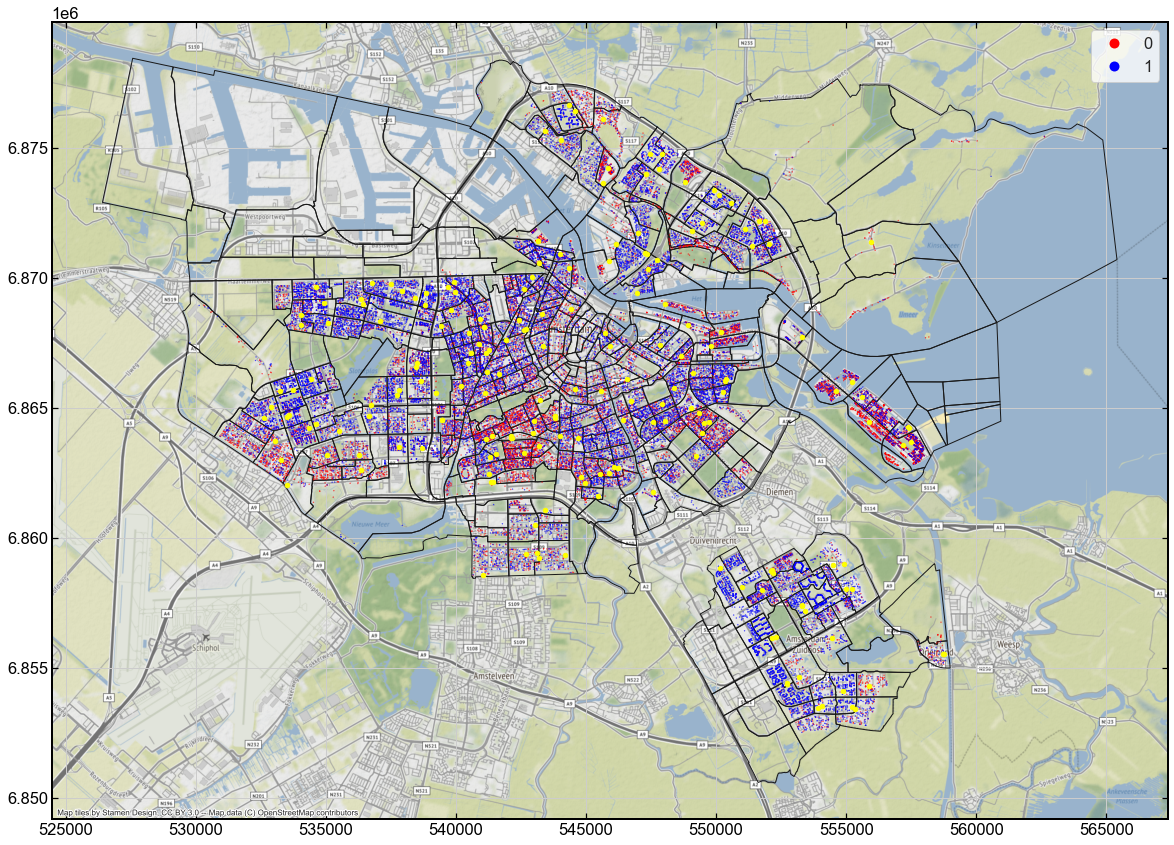

In [5]:
neighbourhoods = gpd.read_file('../compass/maps/amsterdam/buurten-geojson_lnglat.php.json').to_crs("epsg:3857")
schools = gpd.read_file('../compass/maps/amsterdam/school_locations.geojson')

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
neighbourhoods.geometry.boundary.plot(color=None, edgecolor='k', 
                                        linewidth=1, ax=ax, zorder=1)
cx.add_basemap(ax)
cmap = colors.ListedColormap(['red', 'blue'])
households_frame = gpd.GeoDataFrame()
households_frame['Category'] = categories
households_frame['Location'] = points
households_frame.set_geometry('Location', inplace=True)
_ = households_frame.plot(ax=ax, markersize=0.1, categorical=True, 
                          column='Category', cmap=cmap, legend=True)
_ = schools.plot(ax=ax, color='yellow', markersize=20)

In [6]:
max_radius = 5
m = neighbourhoods.explore(
        cmap=None,
        popup=True, style_kwds=dict(color='black'))

schools.explore(m=m, color="yellow", marker_kwds=dict(radius=2, fill=True),
                tooltip=None, tooltip_kwds=dict(labels=False), name="Schools")

household_loc = gpd.GeoSeries([Point(point)]).set_crs("epsg:3857")
household_loc.explore(m=m, color="red", marker_kwds=dict(radius=5, fill=True))
for radius in range(1, max_radius):
    household_loc.buffer(radius*1000).boundary.explore(m=m, color="red", marker_kwds=dict(fill=None))

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control


print('Number of schools within x-km distance: ')
print([(np_distances[rand_int,:] < radius*1000).sum() for radius in range(1,max_radius)])
m

Number of schools within x-km distance: 
[2, 10, 14, 18]


In [7]:
iters = 5
kind = 'Dissim'
max_radius = 5
metrics = []
par_values = []
groups = np.array([(categories==group).astype(int) for group in np.unique(categories)])
plot_data = pd.DataFrame(columns=['Radius (km)', 'School segregation'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.63it/s]


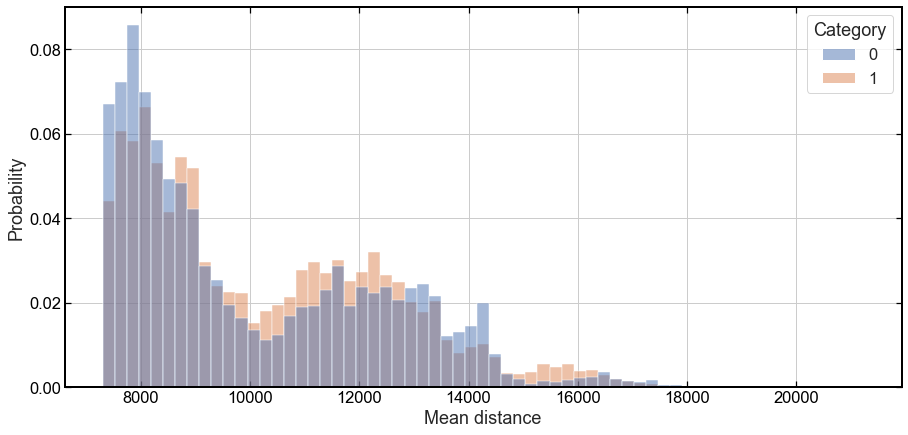

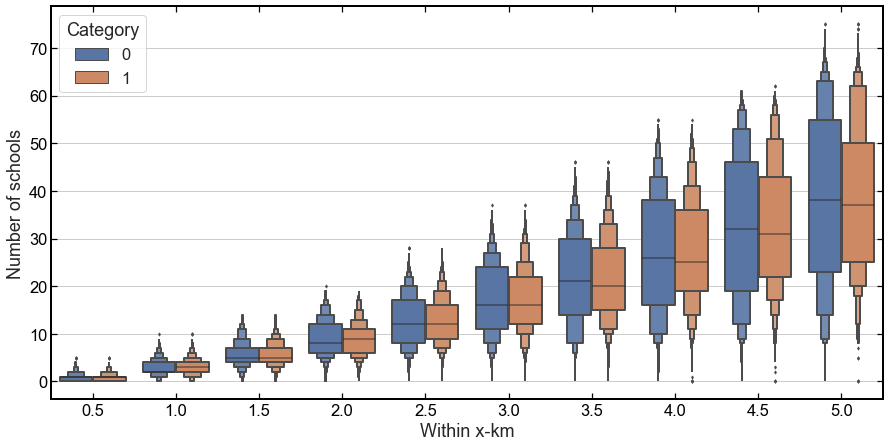

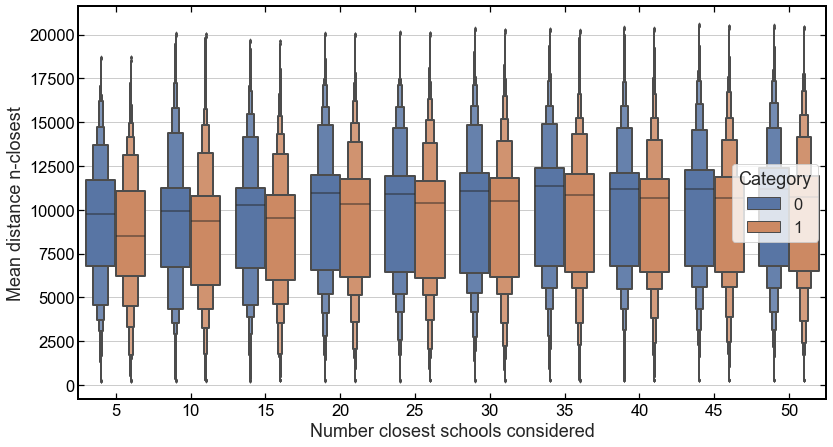

In [17]:
radiuses = []
mean_distances = []
group_categories = []
mean_distances_n = []
number_of_schools = []
schools_considered = []

sorted_distances = np.partition(np_distances, kth=np_distances.shape[1], axis=0)
for radius in tqdm(np.arange(0.5,max_radius+0.5,0.5)):
    
    radiuses += list(np.repeat(radius, len(categories)))
    group_categories += categories
    number_of_schools += list((np_distances < radius*1000).sum(axis=1))
    mean_distances += list(np_distances.mean(axis=1))
    
    n_closest = int(radius*10)
    schools_considered += list(np.repeat(n_closest, len(categories)))
    mean_distances_n += list(sorted_distances[:, :n_closest].mean(axis=1))
    
choice_sets = pd.DataFrame()
choice_sets['Within x-km'] = radiuses
choice_sets['Category'] = group_categories
choice_sets['Number of schools'] = number_of_schools
choice_sets['Mean distance'] = mean_distances
choice_sets['Mean distance n-closest'] = mean_distances_n
choice_sets['Number closest schools considered'] = schools_considered

plot = sns.histplot(data=choice_sets[choice_sets['Within x-km']==1], x='Mean distance', 
                    hue='Category', stat='probability', common_norm=False)
plot.figure.set_size_inches(15,7)
plt.show()

plot = sns.catplot(data=choice_sets, x='Within x-km', y='Number of schools', hue='Category',
                    kind='boxen', legend_out=False, facet_kws=dict(despine=False)
                   )
plot.figure.set_size_inches(15,7)
plt.show()

plot = sns.catplot(data=choice_sets, x='Number closest schools considered', 
                   y='Mean distance n-closest', hue='Category',
                    kind='boxen', legend_out=False, facet_kws=dict(despine=False))
plot.figure.set_size_inches(15,7)
plt.show()

In [18]:
ind_closest = np_distances.argmin(axis=1)
for radius in tqdm(range(max_radius+1)):
    probabilities = choice_set(np_distances, radius, ind_closest)
    par_values += list(np.repeat(radius, iters))
    allocations = np.array([allocate(groups, probabilities, 
                                     actual_households, total_households) for _ in range(iters)])
    metrics += [calculate_segregation(allocation.T, kind) for allocation in allocations]

plot_data['Radius (km)'] = par_values
plot_data['School segregation'] = metrics

means = []
sorted_schools = np.argpartition(np_distances, kth=list(range(np_distances.shape[1])), axis=1)
for n in tqdm([1, 5, sorted_schools.shape[1]]):
    
    probs = np.zeros(np_distances.shape)
    np.put_along_axis(probs, sorted_schools[:,:n], 1, axis=1)
    normed_probs = probs / probs.sum(axis=1)[:,None]
    
    allocations = np.array([allocate(groups, normed_probs,
                                    actual_households, total_households) for _ in range(iters)])
    par_values += [n]*iters
    segregation = [calculate_segregation(allocation.T, kind) for allocation in allocations]
    means += [segregation]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.52s/it]


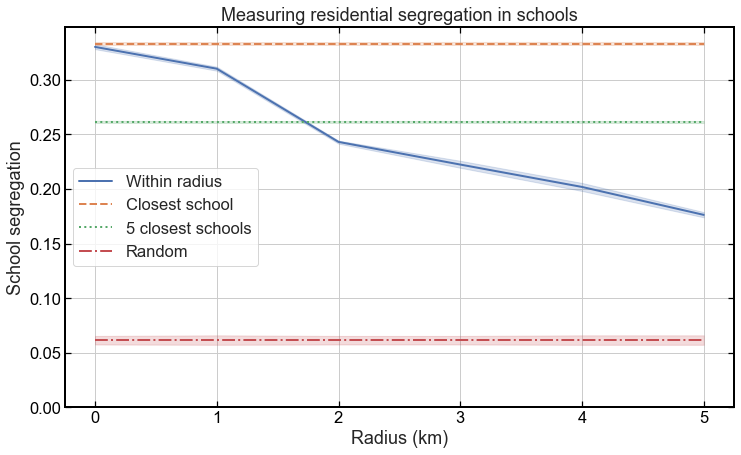

In [19]:
plot = sns.lineplot(data=plot_data, x='Radius (km)', y='School segregation', 
                    label='Within radius')
plot.figure.set_size_inches(12,7)
ls = ['-','--',':','-.','-','--',':','-.','-','--',':','-.',
      '-','--',':','-.','-','--',':','-.','-','--',':','-.']
labels = ['Closest school', '5 closest schools', 'Random']

xs = np.array([[j]*iters for j in range(max_radius+1)]).flatten()

for i in range(len(means)):
    temp_data = pd.DataFrame(columns=['Radius (km)', 'School segregation'])
    temp_data['Radius (km)'] = xs
    temp_data['School segregation'] = np.array(means[i]*(max_radius+1)).flatten()
    _ = sns.lineplot(data=temp_data, x='Radius (km)', y='School segregation',
                   color=sns.color_palette()[i+1], linestyle=ls[i+1], label=labels[i])
_ = plt.legend()
_ = plt.ylim((0,None))
_ = plot.set_title('Measuring residential segregation in schools')